In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
#from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers


ImportError: Matplotlib requires numpy>=1.20; you have 1.19.5

In [1]:
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
uploaded = files.upload()

Saving tripadvisor_hotel_reviews.csv to tripadvisor_hotel_reviews.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['tripadvisor_hotel_reviews.csv']))
print(df)

NameError: name 'pd' is not defined

In [ ]:
df_filtered = df[df["Rating"]!=3]
df_filtered.shape

(18307, 2)

In [ ]:
df_filtered["Rating"] = df_filtered["Rating"].apply(lambda x : 1 if x>3 else 0)

In [ ]:
sorted_data=df_filtered.sort_values('Rating', kind='quicksort', na_position='last')

In [ ]:
final_df=sorted_data.drop_duplicates(subset={"Review","Rating"}, keep='first', inplace=False)
final_df.shape

(18307, 2)

In [ ]:
final_df['Rating'].value_counts()

1    15093
0     3214
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

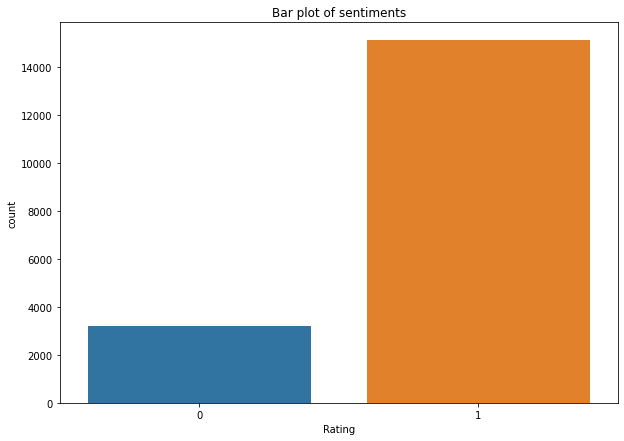

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(final_df['Rating'])
plt.title("Bar plot of sentiments")

In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
final_df['Review'].head()

20490    people talking, ca n't believe excellent ratin...
15861    no room claustrophobic n't stay, room extremel...
15862    rooms, day kowloon hotel wondering possibile r...
15866    great location located mtr station central hon...
15867    problem getting non-smoking room stayed night ...
Name: Review, dtype: object

In [ ]:
a=final_df.loc[final_df['Rating'] != 1]
b=final_df.loc[final_df['Rating'] != 0]
majority_class_len=len(b)
majority_class_len

15093

In [ ]:
minority_class_len=len(a)
minority_class_len

3214

In [ ]:
to_undersample = np.random.choice(final_df[final_df['Rating']  == 1].index, size=majority_class_len-minority_class_len,replace=False)
final_df = final_df.drop(to_undersample)
print('After undersampling: ',len(to_undersample))

After undersampling:  11879


In [ ]:
print(final_df[(final_df.Rating==0)].shape) 
print(final_df[(final_df.Rating==1)].shape)

(3214, 2)
(3214, 2)


In [ ]:
train_df, test_df = train_test_split(final_df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (5142, 2)
Test data size :  (1286, 2)


In [ ]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Review'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Review'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length, padding='post')
y_train = train_df['Rating']

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(input_dim =20000,output_dim = 150, input_length=130))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 150)          3000000   
                                                                 
 lstm (LSTM)                 (None, 50)                40200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3,040,251
Trainable params: 3,040,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
129/129 [==============================] - 39s 303ms/step - loss: 0.6825 - accuracy: 0.5461 - val_loss: 0.6311 - val_accuracy: 0.7852
Epoch 2/15
129/129 [==============================] - 30s 230ms/step - loss: 0.5193 - accuracy: 0.8123 - val_loss: 0.5226 - val_accuracy: 0.7736
Epoch 3/15
129/129 [==============================] - 30s 230ms/step - loss: 0.5002 - accuracy: 0.7967 - val_loss: 0.5495 - val_accuracy: 0.7687
Epoch 4/15
129/129 [==============================] - 30s 233ms/step - loss: 0.4723 - accuracy: 0.8062 - val_loss: 0.5211 - val_accuracy: 0.7716
Epoch 5/15
129/129 [==============================] - 30s 229ms/step - loss: 0.4737 - accuracy: 0.7921 - val_loss: 0.4929 - val_accuracy: 0.7648
Epoch 6/15
129/129 [==============================] - 30s 230ms/step - loss: 0.4787 - accuracy: 0.7795 - val_loss: 0.6516 - val_accuracy: 0.6035
Epoch 7/15
129/129 [==============================] - 30s 230ms/step - loss: 0.5315 - accuracy: 0.7316 - val_loss: 0.4807 - val_ac

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Review'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Rating']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
results = confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.8001555209953344
F1-score:  0.8186309103740296
Confusion matrix:


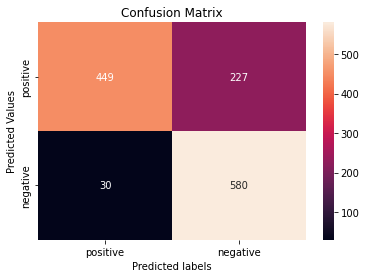

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(results, annot=True, ax = ax, fmt= 'd'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Predicted Values'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);

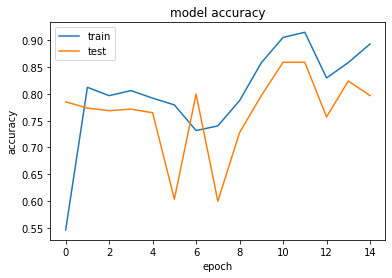

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

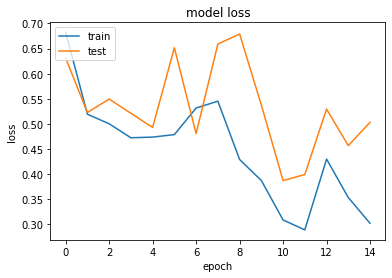

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
text1 = "bad"
text= np.array([text1])
text= tokenizer.texts_to_sequences(text)
text = pad_sequences(text, maxlen=130)
prediction = model.predict(text)
predicted_sentiment = np.argmax(prediction, axis=1)
print(predicted_sentiment)
print(prediction)

[0]
[[0.7271337]]


In [ ]:
import pickle
import joblib
# from sklearn.externals import joblib
model.save('sentiment.h5')
joblib.dump( tokenizer,'tokenizer.pkl')

['tokenizer.pkl']

In [ ]:
model_save_name = 'sentiment.h5'

In [ ]:
path = F"/content/gdrive/model_save_name"

In [ ]:
files.download('sentiment.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>